In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, root_mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV

In [141]:
df = pd.read_csv(r"C:\Users\Robyi\Documents\Data Science Dataset\elecproduction.csv", parse_dates=['DATE'], index_col='DATE')
df.columns = ['Production']
df = df.asfreq('MS')
df = df.sort_index()
df.head()

,Production
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


In [244]:
def create_features(df, lags=12):
    for lag in range(1, lags+1):
        df[f'lag_{lag}'] = df['Production'].shift(lag)
    df['month'] = df.index.month
    df['year'] = df.index.year
    return df.dropna()

df = create_features(df)
df['rolling_mean_30'] = df['Production'].rolling(1).mean()
df['day'] = df.index.day
df['quarter'] = df.index.quarter
df.head()

C:\Users\Robyi\AppData\Local\Temp\ipykernel_11012\1260522619.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rolling_mean_30'] = df['Production'].rolling(1).mean()
C:\Users\Robyi\AppData\Local\Temp\ipykernel_11012\1260522619.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['day'] = df.index.day
C:\Users\Robyi\AppData\Local\Temp\ipykernel_11012\1260522619.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

,Production,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,month,year,day,quarter,rolling_mean_30
DATE,,,,,,,,,,,,,,,,,,
1997-11-01,82.0448,77.5027,81.9386,87.7828,88.4519,79.7645,73.8471,76.1476,83.0125,89.7795,98.4613,90.4855,81.0740,11,1997,1,4,82.0448
1997-12-01,92.1010,82.0448,77.5027,81.9386,87.7828,88.4519,79.7645,73.8471,76.1476,83.0125,89.7795,98.4613,90.4855,12,1997,1,4,92.1010
1998-01-01,94.7920,92.1010,82.0448,77.5027,81.9386,87.7828,88.4519,79.7645,73.8471,76.1476,83.0125,89.7795,98.4613,1,1998,1,1,94.7920
1998-02-01,87.8200,94.7920,92.1010,82.0448,77.5027,81.9386,87.7828,88.4519,79.7645,73.8471,76.1476,83.0125,89.7795,2,1998,1,1,87.8200
1998-03-01,86.5549,87.8200,94.7920,92.1010,82.0448,77.5027,81.9386,87.7828,88.4519,79.7645,73.8471,76.1476,83.0125,3,1998,1,1,86.5549


In [245]:
test_size = 24
train, test = df.iloc[:-test_size], df.iloc[-test_size:]

X_train, y_train = train.drop('Production', axis=1), train['Production']
X_test, y_test = test.drop('Production', axis=1), test['Production']

In [246]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

In [247]:
model = XGBRegressor(objective='reg:squarederror')
tscv = TimeSeriesSplit(n_splits=5)

random_search = RandomizedSearchCV(model, param_grid, n_iter=20,
                                  scoring='neg_mean_squared_error',
                                  cv=tscv, verbose=1, n_jobs=-1)
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=No...
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=None, ...),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.8, 0.9, 1.0],
                                        'learning_rate': [0.01, 0.1, 0.2],
                                        'max_depth': [3, 5, 7],
                                        'n_estimators': [100, 200, 300],
                                        'subsample': [0.8, 0.9, 1.0]},
                   scoring='neg_mean_squared_error', verbose=1)

In [248]:
best_model = random_search.best_estimator_

y_pred = best_model.predict(X_test)

In [249]:
y_pred

array([106.20438 ,  95.20984 ,  89.30492 ,  90.47656 , 103.971344,
       114.375725, 115.41728 , 102.61277 ,  91.23133 ,  92.83082 ,
       112.10845 , 114.782394,  99.468094, 100.93226 ,  88.290306,
        92.05653 , 102.176125, 112.105736, 108.52526 ,  98.35718 ,
        93.583595,  97.31672 , 114.66453 , 123.22023 ], dtype=float32)

In [250]:
y_test

DATE
2016-02-01    106.6688
2016-03-01     95.3548
2016-04-01     89.3254
2016-05-01     90.7369
2016-06-01    104.0375
2016-07-01    114.5397
2016-08-01    115.5159
2016-09-01    102.7637
2016-10-01     91.4867
2016-11-01     92.8900
2016-12-01    112.7694
2017-01-01    114.8505
2017-02-01     99.4901
2017-03-01    101.0396
2017-04-01     88.3530
2017-05-01     92.0805
2017-06-01    102.1532
2017-07-01    112.1538
2017-08-01    108.9312
2017-09-01     98.6154
2017-10-01     93.6137
2017-11-01     97.3359
2017-12-01    114.7212
2018-01-01    129.4048
Freq: MS, Name: Production, dtype: float64

In [251]:
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f"Best Parameters: {random_search.best_params_}")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}")
print(f"MSE: {mse:.2f}%")

Best Parameters: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
MAE: 0.40
RMSE: 1.28
MAPE: 0.00
MSE: 1.64%


In [260]:
X_train.shape

(219, 17)

In [277]:
last_known_values = df.iloc[-1].drop('Production')

future_dates = pd.date_range(start=df.index[-1], periods=30, freq='D')
future_data = pd.DataFrame(index=future_dates)

for col in X_train.columns:
    future_data[col] = last_known_values[col]

future_predictions = best_model.predict(future_data)

future_data['Production_Predicted'] = future_predictions

In [278]:
future_predictions

array([123.22023, 123.22023, 123.22023, 123.22023, 123.22023, 123.22023,
       123.22023, 123.22023, 123.22023, 123.22023, 123.22023, 123.22023,
       123.22023, 123.22023, 123.22023, 123.22023, 123.22023, 123.22023,
       123.22023, 123.22023, 123.22023, 123.22023, 123.22023, 123.22023,
       123.22023, 123.22023, 123.22023, 123.22023, 123.22023, 123.22023],
      dtype=float32)

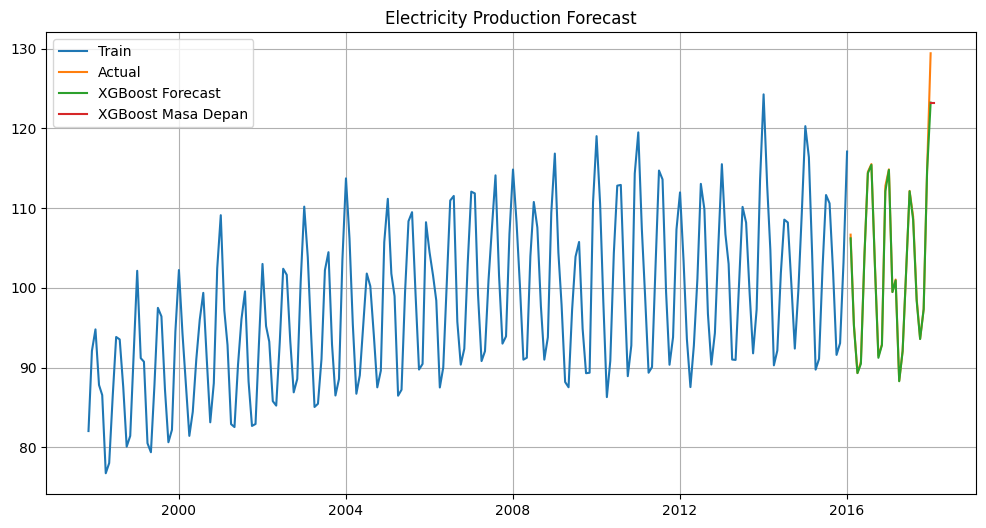

In [279]:
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Production'], label='Train')
plt.plot(test.index, y_test, label='Actual')
plt.plot(test.index, y_pred, label='XGBoost Forecast')
plt.plot(future_dates, future_predictions, label='XGBoost Masa Depan')
plt.title('Electricity Production Forecast')
plt.legend()
plt.grid(True)
plt.show()

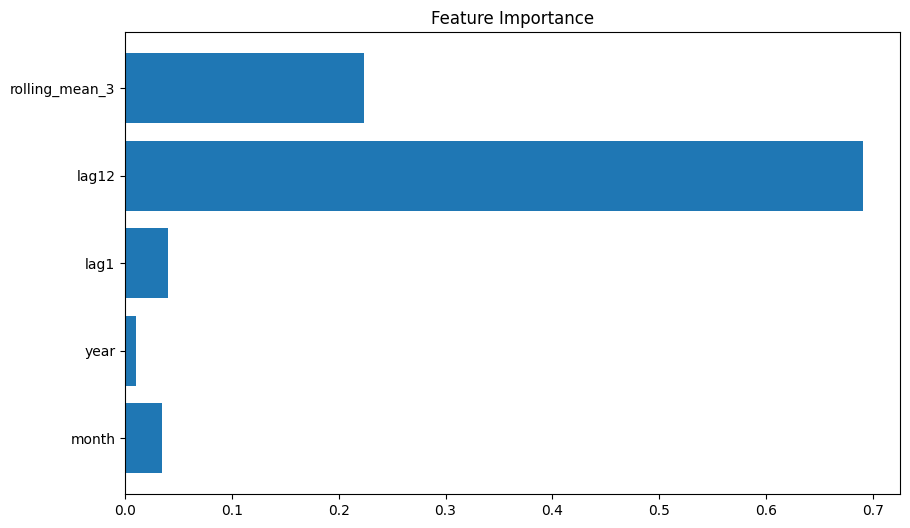

In [92]:
features = list(df_engineered.columns[1:])
plt.figure(figsize=(10,6))
plt.barh(features, best_model.feature_importances_)
plt.title('Feature Importance')
plt.show()